# 8장 합성곱 신경망: 컴퓨터 비전

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 8장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 합성곱 신경망(convnet) 이해
- convnet 재활용

## 8.1 합성곱 신경망 소개

### 예제: MNIST 데이터셋 분류

**convnet 모델 구성**

- `Input()`의 `shape`: `(28, 28, 1)`
- `Conv2D`와 `MaxPooling2D` 층을 함수형 API 방식으로 층쌓기
    - 출력값: 3D 텐서 (높이, 너비, 채널수)
    - 채널수: `filters` 인자로 결정
    - `kernel_size=3`에 유의할 것.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

# 입력층
inputs = keras.Input(shape=(28, 28, 1))

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x) # 1차원 텐서로 변환

# 출력층
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

**모델 구성 요약**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**MNIST 이미지 분류 훈련**

모델 훈련은 이전과 동일하다.

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 39s 9ms/step - loss: 0.1527 - accuracy: 0.9517
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0434 - accuracy: 0.9868
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0298 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0222 - accuracy: 0.9929
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0176 - accuracy: 0.9945


**훈련된 convnet 평가**

테스트셋에 대한 성능이 이전에 사용한 `Sequential` 모델보다 좋아졌다.

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.0395 - accuracy: 0.9893
Test accuracy: 0.989


### 합성곱 연산

- `Dense` 층: 입력값 전체를 학습 대상으로 삼음.
    - MNIST의 경우: 숫자 이미지 전체
- `Conv2D` 층: 예를 들어 `kernel_size=3`으로 설정된 경우
    `3x3` 크기의 국소적 특성만 대상으로 삼음.
    다음 두 가지 장점을 발휘함.

**Conv2D 모델의 장점 1: 위치 독립성**

한 번 인식한 패턴을 다른 위치에서 인실할 수 있다. 
적은 수의 샘플을 이용하여 좋은 성능의 일반화 모델 훈련 가능해진다.   

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/local_patterns.jpg" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**Conv2D 모델의 장점 2: 패턴 공간 계층 파악**

위 층으로 진행할 수록 보다 복잡한 패턴을 파악한다.
이를 **패턴 공간 계층**(spatial hierarchy of patterns)이라 부른다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/visual_hierarchy_hires.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 특성맵, 채널, 필터

합성곱 연산의 작동법을 이해하려면 아래 세 개념을 이해해야 한다.

- **특성맵**(feature maps): 높이, 너비, 깊이로 구성된 3D 텐서
    - 예제: MNIST 샘플의 경우 `(28, 28, 1)` 모양의 3D 텐서.
- **채널**(channel): 특성맵의 깊이를 구성하는 값.
    - 예제: MNIST 데이터 샘플은 흑백 사진이기에 하나의 채널로 구성됨.
    - 예제: 컬러 이미지 샘플은 `(28, 28, 3)` 과 같은 모양의 3D 텐서이기에
        세 개의 채널로 구성됨. 3은 RGB를 나타냄.        
- **필터**(filter): `kernel_size`를 이용한 3D 텐서. 
    - 예제: `kernel_size=3`인 경우 필터는 `(3, 3, 입력특성맵깊이)` 모양의 3D 텐서.
    - 하나의 필터가 하나의 **출력맵**(response map), 즉 하나의 채널을 생성하는 데에 사용됨.
    - 필터 수: `filters` 인자에 의해 결정됨.
    - 출력 특성맵: `(높이, 너비, 필터수)` 모양의 3D 텐서

아래 그림은 MNIST 데이터 샘플에 대해 하나의 필터가 작동하여 하나의 출력맵을 생성하는 과정을 보여준다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/response_map_hires.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

아래 그림은 세 개의 필터를 작동시켜 출력 특성맵을 생성하는 과정을 보여주며
사용된 예제는 다음과 같다.

- 입력 특성맵: `(5, 5, 2)` 모양의 3D 텐서
- 필터 모양: `(3, 3, 2)`
- 필터 개수: 3개
- 출력 특성맵: `(3, 3, 3)` 모양의 3D 텐서

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp/master/notebooks/images/how_convolution_works.jpg" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 합성곱 커널과 합성곱 신경망

필터는 입력 특성맵을 출력 특성맵으로 변환하는 과정에서 사용되는 가중치 행렬이며,
이런 필터를 출력 특성맵의 깊이(채널 수)만큼 모아놓은 (4D) 텐서가 **합성곱 커널**이다.
**합성곱 신경망**은 바로 이 합성곱 커널(필터)을 학습시키는 모델을 가리킨다.

### 패딩과 보폭

입력 특성맵의 높이와 너비가 출력 특성맵의 높이와 너비랑 다를 수 있다.
이는 **패딩**(padding) 사용여부와 **보폭**(stride)의 크기에 의에 결정된다.
다음 세 개의 그림은 입력 특성맵의 높이와 너비가 `5x5`일 때 패딩 여부와 보폭의 크기에 
따라 출력 특성맵의 높이와 너비가 어떻게 달라지는가를 보여준다.

- 경우 1: 패딩 없음, 보폭은 1.
    - 출력 특성맵의 깊이와 너비: `3x3`
    - 즉, 출력 특성맥의 깊이와 너비가 줄어듦.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3x3_patches_in_5x5_input.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 경우 2: 패딩 있음, 보폭은 1.
    - 출력 특성맵의 깊이와 너비: `5x5`
    - 즉, 출력 특성맵의 깊이와 너비가 동일하게 유지됨.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/padding_of_5x5_input.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 경우 3: 패딩 없음, 보폭은 2.
    - 출력 특성맵의 깊이와 너비: `2x2`
    - 즉, 출력 특성맵의 깊이와 너비가 보폭의 반비례해서 줄어듦.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/strides.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

- 경우 4: 패딩 있음, 보폭은 2.
    - 이 경우는 굳이 사용할 필요 없음. 
        이유는 보폭이 1보다 크기에 출력 특성맵의 깊이와 너비가 어차피 보폭에 반비례해서 줄어들기 때문임.

### 맥스 풀링 연산

**맥스 풀링**(max-pooling) 연산은 일정 크기의 영역에서 최댓값만을 선택하여 
특성맵의 깊이와 너비를 일정 비율로 줄인다. 
예를 들어, 아래 맥스 풀링 층은 `2x2`영역에서 최댓값 하나만을 남기고 나머지는 버리며,
이 연산을 보폭 2만큼씩 이동하며 특성맵의 모든 영역(`높이x너비`)에 대해 실행한다.
맥스 풀링 연산은 특성맵, 즉 채녈 별로 별도로 이루어지기에
채널 수는 변하지 않는다.
따라서 만약 `x`가 `(26, 26, 32)` 모양의 3D 텐서이면
다음 맥스 풀링 층의 출력값은 `(13, 13, 32)` 모양의 3D 텐서가 된다.

```python
layers.MaxPooling2D(pool_size=2)(x)
```

<div align="center"><img src="https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png" style="width:500px;"></div>

그림 출처: [GeeksforGeeks: Introduction to Pooling Layer](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

맥스 풀링 층을 합성곱 층(`Conv2D`)와 함께 사용하는 이유는 두 가지이다. 

- 학습해야할 가중치 파라미터의 수 줄이기
- 상위에 위치한 층이 입력 특성맥의 보다 넓은 영역에 대한 정보를 얻도록 하기

아래 코드는 맥스 풀링 층을 사용하지 않는 경우 가중치 파라미터의 수가 엄청나게 증가함을 잘 보여준다. 

- 맥스 풀링 사용하는 경우: 104,202개
- 그렇지 않은 경우: 712,202개

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

### 적절한 `kernel_size`, `stride`, `pool_size`

- `Conv2D` 층의 기본값: `kernel_size=3`, `stride=1`
- `MaxPooling2D` 층의 기본값: `pool_size=2`, `stride=2`

다른 설정 또는 최댓값 대신에 평균값을 사용하는 `AveragePooling2D`를 
활용할 수 있으나 케라스의 기본 설정이 가장 좋은 성능을 보인다.

### 합성곱 신경망의 전형적인 모습

<div align="center"><img src="http://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-03.png" style="width:700px;"></div>

그림 출처: [핸즈온 머신러닝(2판)](https://www.hanbit.co.kr/store/books/look.php?p_code=B7033438574)

## 8.2 합성곱 신경망 실전 활용 예제

개와 고양이 사진을 대상으로 이항분류를 구현하는 모델을 합성곱 신경으로 구현한다.
실전 상황을 묘사하기 위해 5천 개의 이미지로 이루어진 작은 데이터셋을 훈련, 검증, 테스트 용도로 사용한다. 
실제로 훈련셋의 크기가 수 백에서 수 천인 경우가 매우 일반적으로 발생한다.

모델 훈련 과정은 다음과 같다.

- 직접 합성곱 신경망 모델 구현 및 훈련
    - 합성곱 신경망은 작은 크기의 데이터셋으로도 적절한 성능을 얻을 수 있음.
    - 하지만 데이터 증식을 적용하거나 기존에 잘 훈련된 모델을 재활용하여 보다 높은 성능의 모델 구현 가능.
- 데이터 증식 기법 추가
    - 작은 데이터셋의 크기를 늘리는 기법
- 기존에 알려진 모델 재활용
    - 특성 추출 기법
    - 파인 튜닝(fine-tunig)

### 데이터 다운로드

훈련에 필요한 데이터를 다운로드한다.
하지만 이어지는 데이터 다운로드 관련 코드의 실행은 주의를 기울여야 한다.

- 캐글(kaggle) 계정을 갖고 있어야 하며, 로그인된 상태에서 아래 두 과정을 먼저 해결해야 한다.
- 캐글에 로그인한 후 "Account" 페이지의 계정 설정 창에 있는 "API" 항목에서
    "Create New API Token"을 생성하여 다운로드한다.
- [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/rules)를
    방문해서 "I Understand and Accept" 버튼을 클릭해야 한다.

다음 네 개의 이어지는 코드셀은 구글 코랩에서만 실행해야 한다.
현재 구글 코랩을 사용하고 있는지 여부는 아래와 같이 확인할 수 있다.

```python
if 'google.colab' in str(get_ipython()):
    print('구글 코랩 사용중!')
else:
    print('구글 코랩 환경 아님!')
```

개인 PC에서 실행하고자 할 경우 다음 사항들을 고려해야 한다.

- `kaggle.json`: 캐글 API 키를 의미하며, 캐글 웹사이트에 로그인한 후
    "My Account"의 API 섹션에서 하나 생성한 후 다운로드한다.

- `kaggle.json` 파일을 아래 둘째 코드셀에서 
    지정한 경로와 동일한 곳에 저장한 후에 3 단계부터 실행하면 된다.
    단, `kaggle` API가 설치되어 있어야 한다. 
    아니면 주피터 노트북에서 아래 명령문을 실행한다.

    ```python
    !pip install kaggle
    ```

- `kaggle` API를 굳이 설치하지 않으려면 
    [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)에서
    `train.zip` 파일을 다운로드하여 현재 주피터 노트북이 실행되는 디렉토리에 저장한 후에
    4 단계부터 실행하면 된다.

- 다운로드 1단계

In [7]:
if 'google.colab' in str(get_ipython()):
    print('구글 코랩 사용중!')
    from google.colab import files
    files.upload()

print('이어지는 코드는 kaggle.json 파일이 현재 디렉토리에 있다고 가정함.')

구글 코랩 사용중!


Saving kaggle.json to kaggle.json


- 다운로드 2단계: kaggle.json 파일이 현재 워킹 디렉토리에 있다고 가정한 상태에서 아래 명령문 실행.

In [8]:
import os, shutil, pathlib

# kaggle 인증서 현재 저장 위치
where_kaggle_json = pathlib.Path("kaggle.json")

# kaggle 인증서를 사용자 홈디렉토리의 ".kaggle/" 디렉토리로 옮기기
if where_kaggle_json.is_file():
    # 홈디렉토리 경로 지정
    homeDir = pathlib.Path.home()
    kaggleDir = homeDir / ".kaggle"
    kaggleJsonFile = kaggleDir / "kaggle.json"

    # ".kaggle" 디렉토리 존재 여부 확인. 없으면 생성.
    if not kaggleDir.is_dir():
        os.makedirs(kaggleDir)

    # "kaggle.json" 파일 존재 여부 확인. 없으면 복사.
    if not kaggleJsonFile.is_file():
        shutil.copyfile(src=where_kaggle_json, 
                        dst=kaggleJsonFile)
        os.chmod(kaggleJsonFile, 0o600)
else:
    print("kaggle.json 파일을 지정된 사용자 홈폴더의 '.kaggle' 폴더에 저장하세요!")

- 다운로드 3단계: 강아지-고양이 이미지셋 다운로드

In [9]:
# 강아지-고양이 이미지셋 다운로드 및 압축 해제
try: 
    !kaggle competitions download -c dogs-vs-cats
except: 
    !pip install kaggle
    !kaggle competitions download -c dogs-vs-cats

 96% 261M/271M [00:07<00:00, 58.9MB/s]
100% 271M/271M [00:07<00:00, 38.2MB/s]
 99% 538M/543M [00:08<00:00, 73.8MB/s]
100% 543M/543M [00:08<00:00, 65.1MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 74.0MB/s]


- 다운로드 4단계: 압축 풀기

In [10]:
import zipfile

try:
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
except:
    with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    with zipfile.ZipFile('train.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

다운로드된 데이터셋 전체는 총 25,000장의 강아지와 고양이 사진으로 구성되었으며 570MB 정도로 꽤 크다.
강아지와 고양이 각각 12,500 장씩 포함되어 있으며,
사진들의 크기가 다음과 같이 일정하지 않다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dog_and_cat_samples.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**훈련셋, 검증셋, 테스트셋 준비**

25,000 장의 사진 중에서 총 5,000 장의 사진만 사용해서 합성곱 신경을 훈련시키려 한다.

- 훈련셋: 강아지와 고양이 각각 1,000 장
- 검증셋: 강아지와 고양이 각각 500 장
- 테스트셋: 강아지와 고양이 각각 1,000 장

아래 코드는 앞서 지정한 대로 총 5,000 장의 사진으로 이루어진 데이터셋을
추출해서 각각의 디렉토리에 저장한다.
디렉토리의 구성은 다음과 같다.

```
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

In [11]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### 모델 구성

convnet(합성곱 신경망) 모델은 앞서 설명한대로 `Conv2D`와 `MaxPooling2D` 레이어를
연속에서 쌓는 방식을 사용한다.
다만, 보다 복잡한 모델 구성을 위해 보다 높은 층 스택을 쌓는다.

- 입력층: 입력 샘플의 모양을 `(180, 180, 3)`으로 지정. 픽셀 크기는 임의로 지정함.
    사진의 크기가 제 각각이기에 먼저 지정된 크기의 텐서로 변환을 해주는 전처리 과정이 필요함.
- 출력층: 이항분류 모델이기에 한 개의 유닛과 시그모이드 활성화 함수 사용.
- `Rescaling(1./255)` 층: 0에서 255 사이의 값을 0에서 1 사이의 값으로 변환하는 용도로 사용

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# 입력층
inputs = keras.Input(shape=(180, 180, 3))

# 은닉층
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

강아지와 고양이의 비율이 동일하기에 정확도를 평가지표로 사용한다.

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 데이터 전처리

샘플 사진의 크기가 제 각각이기에 모델의 입력값으로 지정된 크기인 `(180, 180, 3)` 모양의 
텐서로 변환을 해주어야 한다.
케라스의 `image_dataset_from_directory()` 함수를 이용하면 변환 뿐만 아니라
지정된 배치 크기의 배치로 구성된 훈련셋, 검증셋, 테스트셋을 쉽게 생성할 수 있다.

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


생성된 `train_dataset`, `validation_dataset`, `test_dataset`은 모두
`BatchDataset` 클래스의 객체이다.

**생성된 데이터셋 항목 확인**

In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**참고**

다음 네 개의 코드셀은 `BatchDataet`의 부모 클래스인 
`Dataset` 자료형의 간단한 기능과 활용법을 보여준다.

- 참고 1: 설명을 위해 넘파이 어레이를 이용하여 `Dataset` 객체 생성
    - `(1000, 16)` 모양의 넘파이 어레이 활용

In [17]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 참고 2: 이터러블 자료형임.

In [18]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 참고 3: `batch()` 메서드 활용

In [19]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 참고 4: `map()` 메서드 활용 예제: 모양 변환

In [20]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**모델 훈련**

- `ModelCheckpoint`: `"val_loss"` 기준으로 최고 성능 모델 저장 

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 121ms/step - loss: 0.7276 - accuracy: 0.5160 - val_loss: 0.6894 - val_accuracy: 0.5570
Epoch 2/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6891 - accuracy: 0.5625 - val_loss: 0.6774 - val_accuracy: 0.5250
Epoch 3/30
63/63 [==============================] - 7s 103ms/step - loss: 0.6738 - accuracy: 0.5970 - val_loss: 0.6516 - val_accuracy: 0.6100
Epoch 4/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6416 - accuracy: 0.6310 - val_loss: 0.5949 - val_accuracy: 0.6820
Epoch 5/30
63/63 [==============================] - 7s 103ms/step - loss: 0.6027 - accuracy: 0.6940 - val_loss: 0.6325 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 7s 102ms/step - loss: 0.5450 - accuracy: 0.7375 - val_loss: 0.6020 - val_accuracy: 0.6900
Epoch 7/30
63/63 [==============================] - 7s 103ms/step - loss: 0.5045 - accuracy: 0.7585 - val_loss: 0.5811 - val_accuracy: 0.7070
Epoch

**훈련 과정 확인**

- 과대 적합이 10번 정도의 에포크 이후에 빠르게 발생

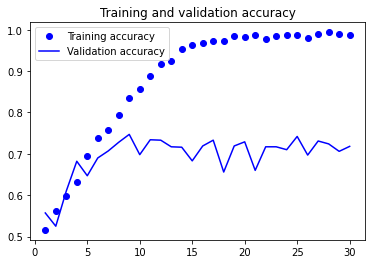

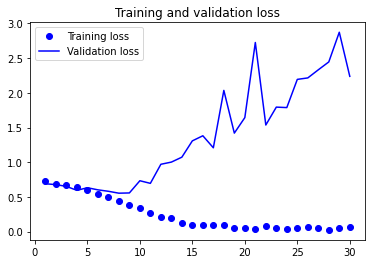

In [22]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**모델 평가**

- 훈련된 최고 성능의 모델에 대한 테스트 결과는 69~70% 정도이다.
- 과대적합이 매우 빠르게 발생한 이유는 훈련셋의 크기가 2,000 정도로 너무 작다.

In [23]:
# 최선 모델 적재
test_model = keras.models.load_model("convnet_from_scratch.keras")

# 테스트 결과
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 50ms/step - loss: 0.5770 - accuracy: 0.7165
Test accuracy: 0.716


### 데이터 증식

데이터 증식 기법을 사용하여 훈련셋의 크기를 키우면,
과대 적합이 보다 늦게 발생하고 따라서 보다 좋은 성능의 모델을 얻게 된다.
케라스의 데이터 증식 층을 이용하여 쉽게 데이터 증식을 구현할 수 있다.
아래 코드는 Sequential 모델을 이용하여 간단하게 데이터 증식 층을 구현한다.

- `RandomFlip()`: 사진을 50%의 확률로 지정된 방향으로 회전. 
- `RandomRotation()`: 사진을 지정된 범위 안에서 임의로 좌우로 회전
- `RandomZoom()`: 사진을 지정된 범위 안에서 임의로 확대 및 축소

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

훈련셋의 첫째 이미지를 대상으로 9번 데이터 증식 기법을 적용한 결과를 
아래와 같이 확인할 수 있다.

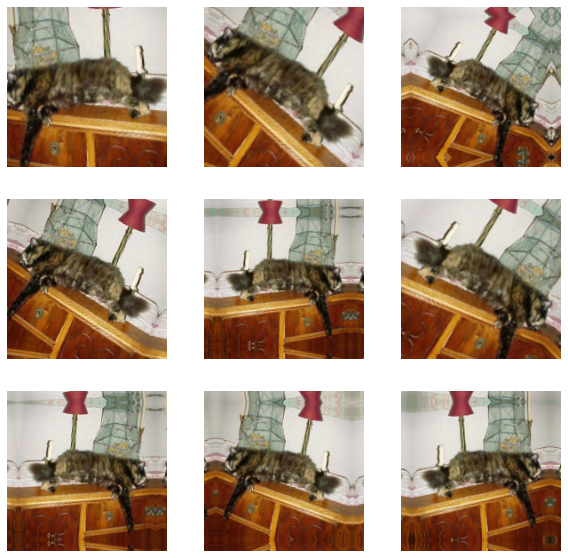

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

모델 구성을 다시 한다. 

- 데이터 증식 포함
- 출력층 바로 이전에 드롭아웃(Dropout) 추가. 과대적합 방지용.

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

모델 훈련은 동일하다. 다만 에포크 수를 100으로 늘린다.
이유는 과대적합이 보다 늦게 발생할 것이기 때문이다.

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 115ms/step - loss: 0.7100 - accuracy: 0.5030 - val_loss: 0.6919 - val_accuracy: 0.5040
Epoch 2/100
63/63 [==============================] - 7s 110ms/step - loss: 0.7000 - accuracy: 0.5230 - val_loss: 0.7466 - val_accuracy: 0.5170
Epoch 3/100
63/63 [==============================] - 7s 110ms/step - loss: 0.6917 - accuracy: 0.5650 - val_loss: 0.6552 - val_accuracy: 0.5750
Epoch 4/100
63/63 [==============================] - 7s 112ms/step - loss: 0.6668 - accuracy: 0.5890 - val_loss: 0.7940 - val_accuracy: 0.5350
Epoch 5/100
63/63 [==============================] - 7s 109ms/step - loss: 0.6383 - accuracy: 0.6395 - val_loss: 0.6686 - val_accuracy: 0.6220
Epoch 6/100
63/63 [==============================] - 7s 112ms/step - loss: 0.6940 - accuracy: 0.6425 - val_loss: 0.6379 - val_accuracy: 0.6340
Epoch 7/100
63/63 [==============================] - 7s 110ms/step - loss: 0.6120 - accuracy: 0.6725 - val_loss: 0.6022 - val_accuracy: 0.6890

과대 적합이 보다 늦게 발생함을 확인할 수 있다.

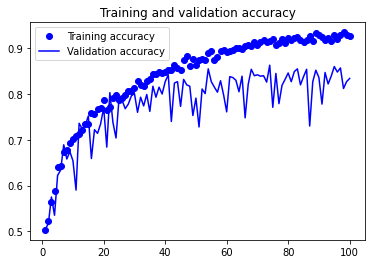

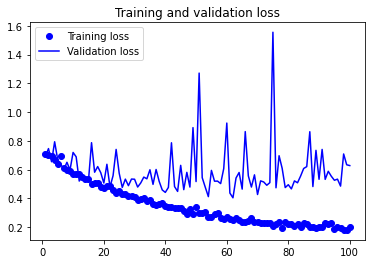

In [28]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

테스트셋에 대한 성능은 83% 정도로 올라갔다.

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 51ms/step - loss: 0.4976 - accuracy: 0.8265
Test accuracy: 0.826


`Conv2D`와 `MaxPooling2D` 층을 더 쌓거나 층에 사용된 필터수를 늘리는 방식으로
모델의 성능을 90% 정도까지 끌어올릴 수는 있지만 그 이상은 어려울 것이다.

**참고**

`convnet_from_scratch_with_augmentation.keras` 모델을 
나중에 재활용하고자 한다. 이를 위해 구글 코랩을 사용하는 경우 모델을 저장해 두어야 한다.

## 8.3 모델 재활용

적은 양의 데이터셋을 대상으로 훈련하는 것보다 대용량의 데이터셋을 이용하여 훈련하면
보다 좋은 성능의 모델을 구현할 수 있다.
하지만 대용량의 데이터를 구하기는 매우 어렵거나 아예 불가능할 수 있다.
대신 유사한 목적으로 대용량의 훈련 데이터셋을 이용하여 훈련된 모델을 재활용할 수 있으며
이를 통해 모델의 성능을 향상시킬 수 있다.
여기서는 기존에 잘 훈련된 모델 VGG16을 재활용하여 강아지와 고양이 사진을 잘 분류하는
모델을 구현하는 두 가지 방식을 소개한다.

- 특성추출(feature extraction)
- 모델 미세조정(fine-tuning)

**모델 재활용 기본 아이디어**

기존에 잘 훈련된 모델은 새롭게 구현하고자 하는 모델과 일반적으로 다른 목적으로 구현되었다.
하지만 예를 들어 강아지와 고양이를 포함한 동물 및 기타 여러 사물을 대상으로 
다중클래스 분류를 목적으로 훈련된 모델은 기본적으로 강아지와 고양이를 
분류하는 능력을 갖고 있어야 한다.

반면에 이항 분류 모델과 다중클래스 분류 모델은 기본적으로 출력층에서 서로 다른 
종류의 값을 출력한다.
고양이와 강아지를 포함해서 총 1000개의 사물 클래스로 이미지를 분류하는 모델의 출력층은 
1000개의 유닛과 softmax 등과 같은 활성화 함수를 사용할 것이지만
고양이-강아지 분류 모델은 1개의 유닛과 sigmoid 등과 같은 활성화 함수를 사용해야 한다.
따라서 기존 모델의 출력층을 포함하여 분류값을 직접적으로 예측하는 마지막 몇 개의 층
(일반적으로 밀집층)을 제외시킨 나머지 합성곱 층으로 이루어진 기저(베이스, base)만을 
가져와서 그 위에 원하는 목적에 맞는 층을 새롭게 구성한다(아래 그림 참조).

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-12.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**VGG16 모델**

VGG16 모델은 [ILSVRC 2014](https://www.image-net.org/challenges/LSVRC/2014/) 
경진대회에 참여해서 5등 안에 든 모델이다.
당시 훈련에 사용된 데이터셋은 120만 장의 이미지와 1,000개의 클래스로 구성되었으며
훈련은 여러 주(weeks)에 걸쳐서 진행되었다. 

<div align="center"><img src="https://www.image-net.org/static_files/figures/ILSVRC2012_val_00042692.png" style="width:700px;"></div>

그림 출처: [ILSVRC 2014](https://www.image-net.org/challenges/LSVRC/2014/)

VGG16 모델 구성은 `Conv2D`와 `MaxPooling2D`의 조합으로 이루어졌다(아래 그림 참조).

<div align="center"><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" style="width:700px;"></div>

그림 출처: [https://neurohive.io/en/popular-networks/vgg16/](https://neurohive.io/en/popular-networks/vgg16/)

**유명 합성곱 신경망 모델**

`ketas.applications` 에 포함된 유명 합성곱 신경모델은 다음과 같다.

- VGG16
- Xception
- ResNet
- MobileNet
- EfficientNet
- DenseNet
- 등등

**이미지넷(ImagNet) 소개**

[이미지넷(Imagenet)](https://www.image-net.org/index.php)은
대용량의 이미지 데이터셋이며, 
[ILSVRC](https://www.image-net.org/challenges/LSVRC/index.php) 
이미지 분류 경진대회에 사용된다.
이미지넷의 전체 데이터셋은 총 2만2천 개 정도의 클래스로 구분되는 동물, 사물 등의 객체를 담은
고화질 사진 1500만장 정도로 구성된다.
2017년까지 진행된 ILSVRC 경진대회는 보통 1000 개의 클래스로 구분되는 
사물을 담은 1백만장 정도 크기의 데이터셋을 이용한다.

<div align="center"><img src="https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_full_1k.jpg" style="width:100%;"></div>

그림 출처: [https://cs.stanford.edu/people/karpathy/cnnembed/](https://cs.stanford.edu/people/karpathy/cnnembed/)

### 재활용 방식 1: 특성 추출

VGG16 합성곱 모델에서 밀집층(dense 층)을 제외한 나머지 합성곱 층으로만 이루어진 모델을 가져온다.

- `weights="imagenet"`: Imagenet 데이터셋으로 훈련된 모델
- `include_top=False`: 출력값을 결정하는 밀집 층 제외
- `input_shape=(180, 180, 3)`: 앞서 준비내 놓은 데이터셋 활용 가능하게 만들기

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


가져온 모델을 요약하면 다음과 같다.

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**특성 추출(feature extraction)은 재활용할 모델을 적용하여
입력 데이터를 변환하여 새로운 입력 데이터셋을 얻는 과정**을 의미한다.

**1) 데이터 증식 없는 특성 추출**

함수 `get_features_and_labels()`는 이전에 준비해 놓은
강아지-고양이 훈련 데이터셋(`train_dataset`)에
VGG16 베이스 모델을 적용하여 
변환된 데이터셋을 생성한다. 
단, 레이블은 그대로 재활용한다. 

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    # 배치 단위로 VGG16 모델 적용
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    # 생성된 배치를 하나의 텐서로 묶어서 반환
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

변환된 데이터는 이제 `(5, 5, 512)` 모양을 갖는다.

In [33]:
train_features.shape

(2000, 5, 5, 512)

변환된 데이터셋을 훈련 데이터셋으로 사용하는 
간단한 분류 모델을 구성하여 훈련만 하면 된다.

In [34]:
# 입력층
inputs = keras.Input(shape=(5, 5, 512))

# 은닉층
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델
model = keras.Model(inputs, outputs)

검증셋에 대한 정확도가 97% 정도까지 향상된다.

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 13ms/step - loss: 26.3330 - accuracy: 0.9210 - val_loss: 4.1021 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3.7013 - accuracy: 0.9795 - val_loss: 4.1080 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1.7168 - accuracy: 0.9860 - val_loss: 5.5454 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 2.0720 - accuracy: 0.9845 - val_loss: 5.5368 - val_accuracy: 0.9740
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.2328 - accuracy: 0.9905 - val_loss: 5.0146 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5921 - accuracy: 0.9960 - val_loss: 5.0712 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0494 - accuracy: 0.9940 - val_loss: 4.9549 - val_accuracy: 0.9790
Epoch 8/20
63/63

훈련 결과를 시각화하면 다음과 같으며,
과대적합이 매우 빠르게 발생함을 확인할 수 있다.
데이터셋의 크기가 너무 작기 때문이며 데이터 증식 기법을 활용할
필요가 있음을 의미한다.

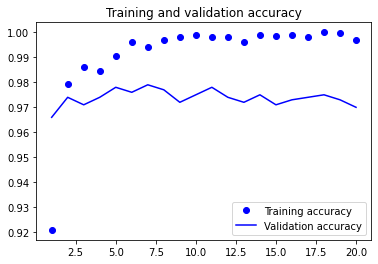

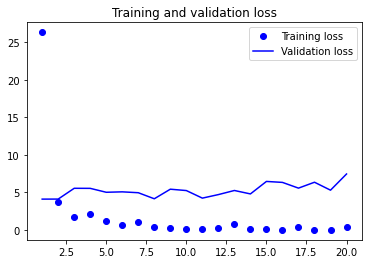

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**2) 데이터 증식 포함 재활용**

데이터 증식 기법을 활용하려면 
VGG16 합성곱 기저(베이스)를 구성요소로 사용하는 모델을 직접 정의해야 한다. 
다만 앞서 설명한 방식과는 달리 가져온 VGG16 기저에 포함된 파라미터가 새로운
모델의 훈련 과정동안 함께 훈련되지 않도록 설정해야 함에 주의해야 한다. 
이런 설정을 **동결**(freezing)이라 한다.

- 기저 동결하기: `trainable=False`로 지정.
- 입력 데이터의 모양도 미리 지정하지 않음에 주의할 것.

In [37]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# 새로운 학습 금지 설정
conv_base.trainable = False

동결 해제(`trainable=True`)로 설정하는 경우와 그렇지 않은 경우 학습되어야 하는
파라미터의 수가 달라짐을 다음처럼 확인할 수 있다.

```python
>>> conv_base.trainable = True
>>> print("합성곱 기저의 학습을 허용하는 경우 학습 가능한 파라미터 수: ", 
          len(conv_base.trainable_weights))
      
합성곱 기저의 학습을 허용하는 경우 학습 가능한 파라미터 수: 26
```

동결 설정(`trainable=False`)인 경우에 학습되는 파라미터 수가 0이 된다. 

```python
>>> conv_base.trainable = True
>>> print("합성곱 기저의 학습을 금지하는 경우 학습 가능한 파라미터 수: ", 
          len(conv_base.trainable_weights))
      
합성곱 기저의 학습을 허용하는 경우 학습 가능한 파라미터 수: 0
```

아래 모델은 데이터 증식을 위한 층과 VGG16 기저를 함께 이용한다.

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# 모델 구성
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)                      # 데이터 증식
x = keras.applications.vgg16.preprocess_input(x)   # VGG16 베이스
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x) # 출력층

model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

이렇게 훈련하면 재활용된 합성곱 기저에 속한 층은 학습하지 않으며
두 개의 밀집층에서만 파라미터 학습이 이뤄진다.

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 21s 299ms/step - loss: 19.3769 - accuracy: 0.8975 - val_loss: 3.7918 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 19s 291ms/step - loss: 6.9565 - accuracy: 0.9415 - val_loss: 7.7983 - val_accuracy: 0.9530
Epoch 3/50
63/63 [==============================] - 19s 291ms/step - loss: 5.6898 - accuracy: 0.9535 - val_loss: 4.7947 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 19s 291ms/step - loss: 3.9247 - accuracy: 0.9625 - val_loss: 3.8535 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 19s 292ms/step - loss: 4.1441 - accuracy: 0.9670 - val_loss: 5.8417 - val_accuracy: 0.9540
Epoch 6/50
63/63 [==============================] - 19s 292ms/step - loss: 3.8200 - accuracy: 0.9675 - val_loss: 4.5870 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 19s 293ms/step - loss: 2.8147 - accuracy: 0.9750 - val_loss: 4.0268 - val_accuracy: 0.972

과대적합이 보다 늦게 이루어지며 성능도 향상되었다.

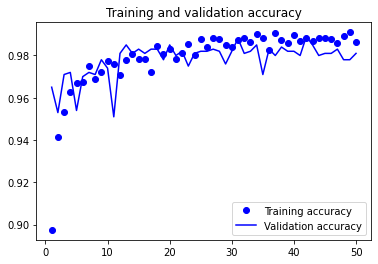

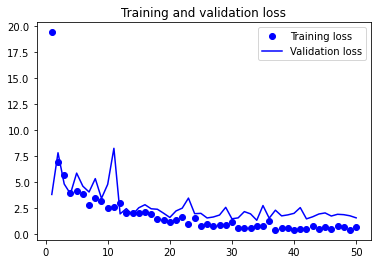

In [40]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

테스트셋에 대한 정확도가 97.7%까지 향상된다.

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 184ms/step - loss: 2.4845 - accuracy: 0.9770
Test accuracy: 0.977


### 재활용 방식 2: 모델 미세 조정

모델 **미세 조정**(파인 튜닝, fine-tuning)은 특성 추출 방식과는 달리
기존 합성곱 모델의 최상위 합성곱 층 몇 개를 동결 해제해서
새로운 모델에 맞추어 학습되도록 하는 모델 훈련기법이다.

여기서는 아래 그림에처럼 노락색 배경을 가진 상자 안에 포함된 합성곱 층을 
동결 해제해서 함께 학습되도록 한다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/08-15.png" style="width:200px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

아래 코드는 모든 층에 대해 동결해제를 진행한 후에
마지막 4개 층을 제외한 나머지 층에 대해 다시 동결을 설정한다.

In [42]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

상위 4개 층만 동결 해제하는 이유는
합성곱 신경망의 하위층은 보다 일반적인 형태의 패턴을 학습하는 반면에
최상위층은 주어진 문제 해결에 특화된 패턴을 학습하기 때문이다.
따라서 이미지넷으로 훈련된 모델 전체를 대상으로 훈련하기 보다는
최상위층만 훈련시키는 것이 보다 유용하다.

모델 컴파일과 훈련 과정은 이전과 동일하게 진행한다.

In [43]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 23s 329ms/step - loss: 0.2703 - accuracy: 0.9920 - val_loss: 1.7308 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - 20s 320ms/step - loss: 0.3606 - accuracy: 0.9910 - val_loss: 2.0407 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 20s 320ms/step - loss: 0.3974 - accuracy: 0.9900 - val_loss: 1.8677 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 21s 324ms/step - loss: 0.3919 - accuracy: 0.9925 - val_loss: 1.6572 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 20s 320ms/step - loss: 0.2048 - accuracy: 0.9940 - val_loss: 1.7202 - val_accuracy: 0.9750
Epoch 6/30
63/63 [==============================] - 21s 325ms/step - loss: 0.3171 - accuracy: 0.9885 - val_loss: 1.4926 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 20s 321ms/step - loss: 0.4161 - accuracy: 0.9905 - val_loss: 1.6353 - val_accuracy: 0.9790

기존 모델을 재활용하여 98%($\pm\!$ 1%)에 육박하는 정확도 성능을 갖는
합성곱 신경망 모델을 2,0000개의 이미지만으로 학습시켰음을
확인할 수 있다.

In [44]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 185ms/step - loss: 1.8448 - accuracy: 0.9745
Test accuracy: 0.975
